In [105]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import glob
import torch
from tqdm.notebook import tqdm
from RolloutDataset import RolloutDataset
from FCNetwork import FCNetwork
from hyperparams import params
import pdb
%matplotlib notebook
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [106]:
files = glob.glob('rollouts/*.npy')
n_rollouts = 500
files = files[:n_rollouts]
rollouts = []
for file in tqdm(files):
    rollout = np.load(file)
    rollouts.append(rollout)
rollouts = np.stack(rollouts)
cutoff = int(round(.7*len(rollouts)))
val_rollouts = rollouts[cutoff:]
del rollouts

In [107]:
model_path = params['model path']
dropout = params['dropout']
hidden_layers = params['hidden layers']
hidden_size = params['hidden size']

n_ahead = 500

val_dataset = RolloutDataset(val_rollouts, n_ahead = n_ahead)
action_size = len(val_dataset[0][0][0])
state_size = len(val_dataset[0][1])
output_size = len(val_dataset[0][2][0])

model = FCNetwork(action_size = action_size,
                 state_size = state_size,
                 output_size = output_size,
                 hidden_layers = hidden_layers,
                 hidden_size = hidden_size,
                 dropout = dropout)
model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [108]:
def plot_obs(frame, color, label, ax):
    x_coords = frame[0::12]
    y_coords = frame[1::12]
    z_coords = frame[2::12]
    ax.scatter(x_coords, z_coords, y_coords, alpha=.2, color=color, label=label)

<IPython.core.display.Javascript object>


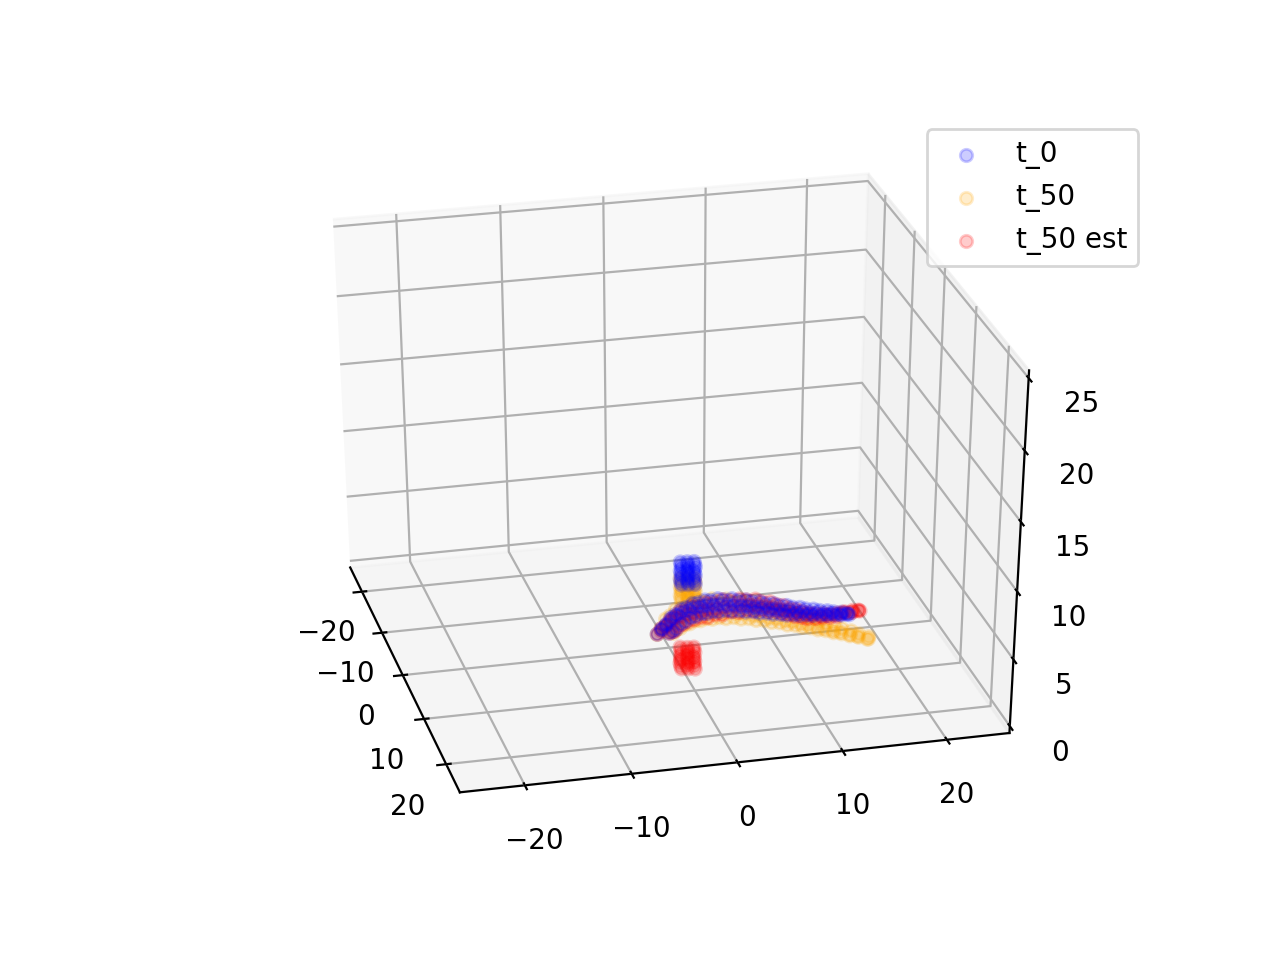

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
coord_min = -25
coord_max = 25
ax.set_xlim([coord_min, coord_max])
ax.set_ylim([coord_min, coord_max])
ax.set_zlim([0, coord_max])

r = np.random.randint(len(val_dataset))
t = 50
actions, state0, deltas = val_dataset[r]
actions, state0, deltas = torch.Tensor(actions).to(device), torch.Tensor(state0).to(device), torch.Tensor(deltas).to(device)
state_t = state0 + deltas[t]

s = state0.float().to(device)
a = actions.float().to(device)
d = deltas.float().to(device)

d_est = torch.zeros(d.shape).to(device)

model.eval()
with torch.no_grad():
    for i in range(n_ahead):
        action = a[i]
        d_hat = model(action.unsqueeze(0), s.unsqueeze(0)).squeeze(0)
        
        if i == 0:
            d_est[i] = d_hat
        else:
            d_est[i] = d_est[i-1] + d_hat
        s = s + d_hat

state_est = state0 + d_est[t]
plot_obs(state0.cpu(), 'blue', 't_0', ax)
plot_obs(state_t.cpu(), 'orange', f't_{t}', ax)
plot_obs(state_est.cpu(), 'red', f't_{t} est', ax)
plt.legend()
plt.show()